In [ ]:
# for now i haven't used the validation set
# this model was partially constructed following a tutorial, but did experiment with different ways to construct the model 

In [3]:
!pip install transformers
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import DataLoader, Dataset, RandomSampler
import math

# specify GPU
device = torch.device("cuda")

     |████████████████████████████████| 3.1 MB 4.3 MB/s 
     |████████████████████████████████| 596 kB 27.2 MB/s 
     |████████████████████████████████| 895 kB 43.0 MB/s 
     |████████████████████████████████| 3.3 MB 46.4 MB/s 
     |████████████████████████████████| 59 kB 6.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased', return_dict=False)


# freezing the model's parameters
for param in bert.parameters():
    param.requires_grad = False

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [5]:
data = pd.read_csv("/content/spam.csv", encoding="ISO-8859-1")[["v1", "v2"]]
labels = data['v1'].tolist()
# labels[0:5]
le = preprocessing.LabelEncoder()
binary_labels = le.fit_transform(labels)
binary_labels = torch.tensor(binary_labels)
# binary_labels[0:5]

In [6]:
text = data['v2'].tolist()

In [7]:
# train test validation split
train_text, temp_text, train_labels, temp_labels = train_test_split(text, binary_labels, 
                                                                    random_state=0, 
                                                                    test_size=0.3)

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=0, 
                                                                test_size=0.5)

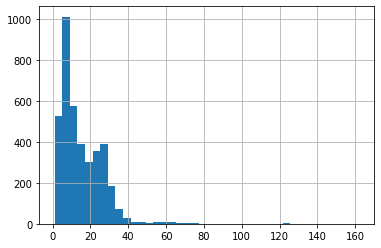

In [8]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 40)

In [9]:
max_seq_len = 30

In [10]:
tokenized_training_data = tokenizer.__call__(train_text, 
                                   max_length=max_seq_len, 
                                   truncation=True,
                                   padding=True,
                                   return_token_type_ids=False,
                                  return_tensors="pt")

tokenized_val_data = tokenizer.__call__(val_text, 
                              max_length=max_seq_len, 
                              truncation=True,
                              padding=True,
                              return_token_type_ids=False,
                             return_tensors="pt")

tokenized_test_data = tokenizer.__call__(test_text, 
                               max_length=max_seq_len, 
                               truncation=True, 
                               padding=True,
                               return_token_type_ids=False,
                               return_tensors="pt")
# tokenized_training_data.keys()

In [11]:
class SpamDataset(Dataset):

    def __init__(self, training_data, labels):
        # Initialize data, download, etc.
        # read with numpy or pandas
        self.training_data = training_data
        self.labels = labels
        self.n_samples = len(labels)


    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        # returns (input_id, attention_mask, label)
        return (self.training_data['input_ids'][index], self.training_data['attention_mask'][index], self.labels[index])

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [12]:
class Spam_Model(nn.Module):
    def __init__(self, bert):
        super(Spam_Model, self).__init__()
        self.bert = bert
#         self.relu_1 = nn.ReLU()

        self.L1 = nn.Linear(768, 265)
        self.relu = nn.ReLU()
        self.L2 = nn.Linear(265, 1)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, sent_id, mask):
            _, cls_hs = self.bert(sent_id, attention_mask=mask)
            output = self.L1(cls_hs)
#             print(output)
            output = self.relu(output)
            output = self.L2(output)
            output = self.sigmoid(output)
            return output 

In [13]:
type(train_labels)

torch.Tensor

In [14]:
train_data = SpamDataset(tokenized_training_data, train_labels)
val_data = SpamDataset(tokenized_val_data, val_labels)
test_data = SpamDataset(tokenized_test_data, test_labels)

In [15]:
train_sampler = RandomSampler(train_data)

training_data_loader = DataLoader(train_data, batch_size=4, sampler=train_sampler)
val_data_loader = DataLoader(val_data, batch_size=4, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=4, shuffle=True)

In [16]:
# train_dataiter = iter(training_data_loader)
# val_dataiter = iter(val_data_loader)
# test_dataiter = iter(test_data_loader)

In [17]:
# output = train_dataiter.next()
# # len(output[0])
# output[0][0]
# # verbose, cls_hs= bert(train_dataiter.next())

# for data in train_dataiter:
#     print(data)
    
# len(data[0])
# data

In [18]:
learning_rate = 0.001

model = Spam_Model(bert)
# model = model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)  


In [21]:
# Dummy Training loop
i=0
num_epochs = 5
total_samples = len(training_data_loader)
n_iterations = math.ceil(total_samples/4)
total_loss = 0
# print(total_samples, n_iterations)
for epoch in range(num_epochs):
    for i, (sent_id, mask, labels) in enumerate(training_data_loader):
        optimizer.zero_grad()

        # Forward pass
#         sent_id = sent_id.to(device)
#         mask= mask.to(device)
#         labels = labels.to(device)
        outputs = model(sent_id, mask)
#         print(outputs)
#         print(labels)
        loss = criterion(outputs[:, 0], labels.float())
        total_loss += loss
#         print(loss)
        # Backward and optimize



        loss.backward()
        optimizer.step()
        if (i+1) % 50 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_samples}], Total Loss: {total_loss.item():.4f}, Loss: {loss.item():.4f}')
            total_loss = 0


Epoch [1/5], Step [50/975], Total Loss: 19.2349, Loss: 0.1436
Epoch [1/5], Step [100/975], Total Loss: 22.1977, Loss: 0.2248
Epoch [1/5], Step [150/975], Total Loss: 15.9907, Loss: 0.4090
Epoch [1/5], Step [200/975], Total Loss: 14.2288, Loss: 0.1115
Epoch [1/5], Step [250/975], Total Loss: 13.1524, Loss: 0.5360
Epoch [1/5], Step [300/975], Total Loss: 14.9636, Loss: 0.0186
Epoch [1/5], Step [350/975], Total Loss: 16.7278, Loss: 0.0551
Epoch [1/5], Step [400/975], Total Loss: 13.8620, Loss: 0.5877
Epoch [1/5], Step [450/975], Total Loss: 10.1945, Loss: 0.0056
Epoch [1/5], Step [500/975], Total Loss: 13.7021, Loss: 0.0350
Epoch [1/5], Step [550/975], Total Loss: 9.1215, Loss: 0.1923
Epoch [1/5], Step [600/975], Total Loss: 11.4117, Loss: 0.0576
Epoch [1/5], Step [650/975], Total Loss: 13.6097, Loss: 0.0085
Epoch [1/5], Step [700/975], Total Loss: 11.6032, Loss: 0.9411
Epoch [1/5], Step [750/975], Total Loss: 11.0624, Loss: 0.1950
Epoch [1/5], Step [800/975], Total Loss: 12.1766, Loss: 0

In [24]:
correct_guesses = 0
false_guesses = 0
for i, (sent_id, mask, label) in enumerate(test_data_loader):
    with torch.no_grad():
        preds = model(sent_id, mask)
        for i in range(len(preds)):
            # print(int(round(float(preds[i][0]))))
            if int(round(float(preds[i][0]))) == label[i]:
                correct_guesses += 1
            else:
                false_guesses += 1
#             preds = preds.detach().cpu().numpy()


In [25]:
# accuracy= 0.9593301435406698
print(correct_guesses/(correct_guesses + false_guesses))

0.9593301435406698


In [26]:
# # example

# from transformers import AutoTokenizer, TFAutoModel

# # tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# ex_inputs = tokenizer(["Hello world!", "hello world 2"], return_tensors="pt")


# # # The ** operator allows us to take a dictionary of key-value pairs and unpack it into keyword arguments in a ***function call***
# ex_outputs = bert(**ex_inputs)

# ex_outputs 

# # print(ex_outputs.last_hidden_state.shape)
# # print(ex_outputs[0].shape)


# # print(ex_outputs.pooler_output.shape)
# print(ex_outputs[1].shape)

# # false usage (used in function calls)
# # print(**ex_inputs.items())
